# SPP Analysis Tutorial: Large Amplitude Oscillatory Shear (LAOS)

This notebook demonstrates the SPP (Sequence of Physical Processes) decomposition in RheoJAX for analyzing Large Amplitude Oscillatory Shear (LAOS) experiments.

## Overview

The SPP framework (Rogers et al., J. Rheol. 2012) provides cycle-by-cycle analysis of nonlinear viscoelastic responses. Unlike traditional LAOS analysis that reports single values per cycle, SPP extracts **time-resolved** material functions:

- **G'_t, G''_t**: Time-resolved storage and loss moduli
- **|G*_t|**: Complex modulus magnitude throughout the cycle
- **δ_t**: Time-resolved phase angle
- **Yield stresses**: Static (σ_sy) and dynamic (σ_dy)
- **Lissajous metrics**: G_L, G_M, S-factor, T-factor

## Learning Objectives

1. Load and prepare LAOS data for SPP analysis
2. Configure and apply SPPDecomposer
3. Interpret time-resolved moduli and phase angles
4. Analyze strain amplitude dependence
5. Extract yield stresses and nonlinearity metrics

In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install rheojax

# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

In [2]:
# Standard imports
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

# RheoJAX imports
from rheojax.core.data import RheoData
from rheojax.transforms import SPPDecomposer

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("RheoJAX SPP Analysis Tutorial")
print("="*40)

RheoJAX SPP Analysis Tutorial


## 1. Understanding LAOS Data

LAOS experiments apply sinusoidal strain and measure the resulting stress:

- **Input**: γ(t) = γ₀ sin(ωt) — sinusoidal strain
- **Output**: σ(t) — stress response (nonlinear for large γ₀)

Key parameters:
- **ω**: Angular frequency (rad/s)
- **γ₀**: Strain amplitude (dimensionless)
- **γ̇₀ = ω·γ₀**: Strain rate amplitude (1/s)

In [3]:
def load_laos_data(filepath: str) -> dict:
    """Load LAOS data from a text file.
    
    Expected format: 4 columns (tab or space separated)
        Column 1: Time [s]
        Column 2: Strain [-] (may need scaling)
        Column 3: (Optional) Raw signal/torque
        Column 4: Stress [Pa]
    
    Parameters
    ----------
    filepath : str
        Path to the LAOS data file
    
    Returns
    -------
    dict
        Dictionary with time, strain, strain_rate, stress arrays
    """
    data = np.loadtxt(filepath)
    
    time = data[:, 0]  # Time [s]
    
    # Check if strain needs scaling (common convention: strain × 100)
    raw_strain = data[:, 1]
    if np.max(np.abs(raw_strain)) > 10:  # Likely in percentage
        strain = raw_strain / 100.0
    else:
        strain = raw_strain
    
    # Stress is typically the last column
    stress = data[:, -1]  # Stress [Pa]
    
    # Compute strain rate via numerical differentiation
    dt = time[1] - time[0] if len(time) > 1 else 0.001
    strain_rate = np.gradient(strain, dt)
    
    return {
        'time': time,
        'strain': strain,
        'strain_rate': strain_rate,
        'stress': stress,
        'dt': dt,
    }


def generate_synthetic_laos(
    omega: float = 1.0,
    gamma_0: float = 1.0,
    n_points: int = 1024,
    n_cycles: int = 1,
    G_elastic: float = 100.0,
    G_viscous: float = 50.0,
    nonlinearity: float = 0.1,
) -> dict:
    """Generate synthetic LAOS data for demonstration.
    
    Creates a nonlinear viscoelastic response with controllable
    elastic/viscous contributions and higher harmonic content.
    
    Parameters
    ----------
    omega : float
        Angular frequency (rad/s)
    gamma_0 : float
        Strain amplitude
    n_points : int
        Number of data points
    n_cycles : int
        Number of oscillation cycles
    G_elastic : float
        Elastic modulus contribution (Pa)
    G_viscous : float
        Viscous modulus contribution (Pa)
    nonlinearity : float
        Third harmonic amplitude (0 = linear, 0.1 = 10% nonlinearity)
    
    Returns
    -------
    dict
        Dictionary with time, strain, strain_rate, stress arrays
    """
    # Time array for specified cycles
    T_period = 2 * np.pi / omega
    t_max = n_cycles * T_period
    time = np.linspace(0, t_max, n_points, endpoint=False)
    dt = time[1] - time[0]
    
    # Strain input (sinusoidal)
    strain = gamma_0 * np.sin(omega * time)
    strain_rate = gamma_0 * omega * np.cos(omega * time)
    
    # Stress response (Kelvin-Voigt with nonlinearity)
    # Linear response: σ = G' γ + η γ̇ = G' γ + (G''/ω) γ̇
    sigma_elastic = G_elastic * strain
    sigma_viscous = (G_viscous / omega) * strain_rate
    
    # Add third harmonic nonlinearity (characteristic of LAOS)
    sigma_3rd = nonlinearity * G_elastic * gamma_0 * np.sin(3 * omega * time)
    
    stress = sigma_elastic + sigma_viscous + sigma_3rd
    
    return {
        'time': time,
        'strain': strain,
        'strain_rate': strain_rate,
        'stress': stress,
        'dt': dt,
        'omega': omega,
        'gamma_0': gamma_0,
    }

In [4]:
# Define experimental parameters
OMEGA = 3.16  # rad/s (angular frequency)

# Three strain amplitudes for amplitude sweep
EXPERIMENTS = {
    'low': {'gamma_0': 0.1, 'n_harmonics': 15, 'nonlinearity': 0.02},
    'medium': {'gamma_0': 1.0, 'n_harmonics': 39, 'nonlinearity': 0.10},
    'high': {'gamma_0': 10.0, 'n_harmonics': 81, 'nonlinearity': 0.25},
}

print(f"Angular frequency: ω = {OMEGA} rad/s")
print(f"Period: T = {2*np.pi/OMEGA:.3f} s")
print(f"\nStrain amplitude sweep:")
for name, params in EXPERIMENTS.items():
    gamma_dot_0 = OMEGA * params['gamma_0']
    print(f"  {name}: γ₀ = {params['gamma_0']}, γ̇₀ = {gamma_dot_0:.2f} 1/s")

Angular frequency: ω = 3.16 rad/s
Period: T = 1.988 s

Strain amplitude sweep:
  low: γ₀ = 0.1, γ̇₀ = 0.32 1/s
  medium: γ₀ = 1.0, γ̇₀ = 3.16 1/s
  high: γ₀ = 10.0, γ̇₀ = 31.60 1/s


In [5]:
# Try to load real data, fall back to synthetic if not available
# Data is stored in the examples/data/laos directory
import os

# Get the directory containing this notebook and navigate to data
NOTEBOOK_DIR = Path(os.getcwd())
DATA_DIR = NOTEBOOK_DIR.parent / "data" / "laos"

# If running from examples/advanced, this should work
if not DATA_DIR.exists():
    # Try alternative path (running from repo root)
    DATA_DIR = Path("examples/data/laos")

DATA_FILES = {
    'low': 'raw_signal_0010.txt',
    'medium': 'raw_signal_0100.txt',
    'high': 'raw_signal_1000.txt',
}

laos_datasets = {}
using_synthetic = False

for name, params in EXPERIMENTS.items():
    filepath = DATA_DIR / DATA_FILES[name]

    if filepath.exists():
        laos_datasets[name] = load_laos_data(str(filepath))
        laos_datasets[name]['omega'] = OMEGA
        laos_datasets[name]['gamma_0'] = params['gamma_0']
        print(f"Loaded real data: {name} (γ₀ = {params['gamma_0']})")
    else:
        # Generate synthetic data
        using_synthetic = True
        laos_datasets[name] = generate_synthetic_laos(
            omega=OMEGA,
            gamma_0=params['gamma_0'],
            n_points=1024,
            n_cycles=1,
            G_elastic=20.0,
            G_viscous=10.0,
            nonlinearity=params['nonlinearity'],
        )
        print(f"Generated synthetic data: {name} (γ₀ = {params['gamma_0']})")

if using_synthetic:
    print("\nNote: Using synthetic data for demonstration.")
    print(f"For real data, place LAOS files in: {DATA_DIR}")

Loaded real data: low (γ₀ = 0.1)
Loaded real data: medium (γ₀ = 1.0)
Loaded real data: high (γ₀ = 10.0)


In [6]:
# Examine the medium amplitude dataset
data = laos_datasets['medium']

print(f"Dataset: medium (γ₀ = {data['gamma_0']})")
print(f"  Points: {len(data['time'])}")
print(f"  Time range: {data['time'][0]:.4f} - {data['time'][-1]:.4f} s")
print(f"  Strain range: {data['strain'].min():.4f} to {data['strain'].max():.4f}")
print(f"  Stress range: {data['stress'].min():.2f} to {data['stress'].max():.2f} Pa")
print(f"  dt: {data['dt']:.6f} s")

Dataset: medium (γ₀ = 1.0)
  Points: 1024
  Time range: 0.0000 - 1.9864 s
  Strain range: -1.0000 to 1.0000
  Stress range: -25.80 to 25.80 Pa
  dt: 0.001942 s


## 2. Visualizing LAOS Waveforms

Before SPP analysis, let's visualize the raw LAOS data using standard representations:

1. **Time domain**: Strain and stress waveforms
2. **Elastic Lissajous**: Stress vs. strain (σ vs γ)
3. **Viscous Lissajous**: Stress vs. strain rate (σ vs γ̇)
4. **Phase portrait**: Strain rate vs. strain (γ̇ vs γ)

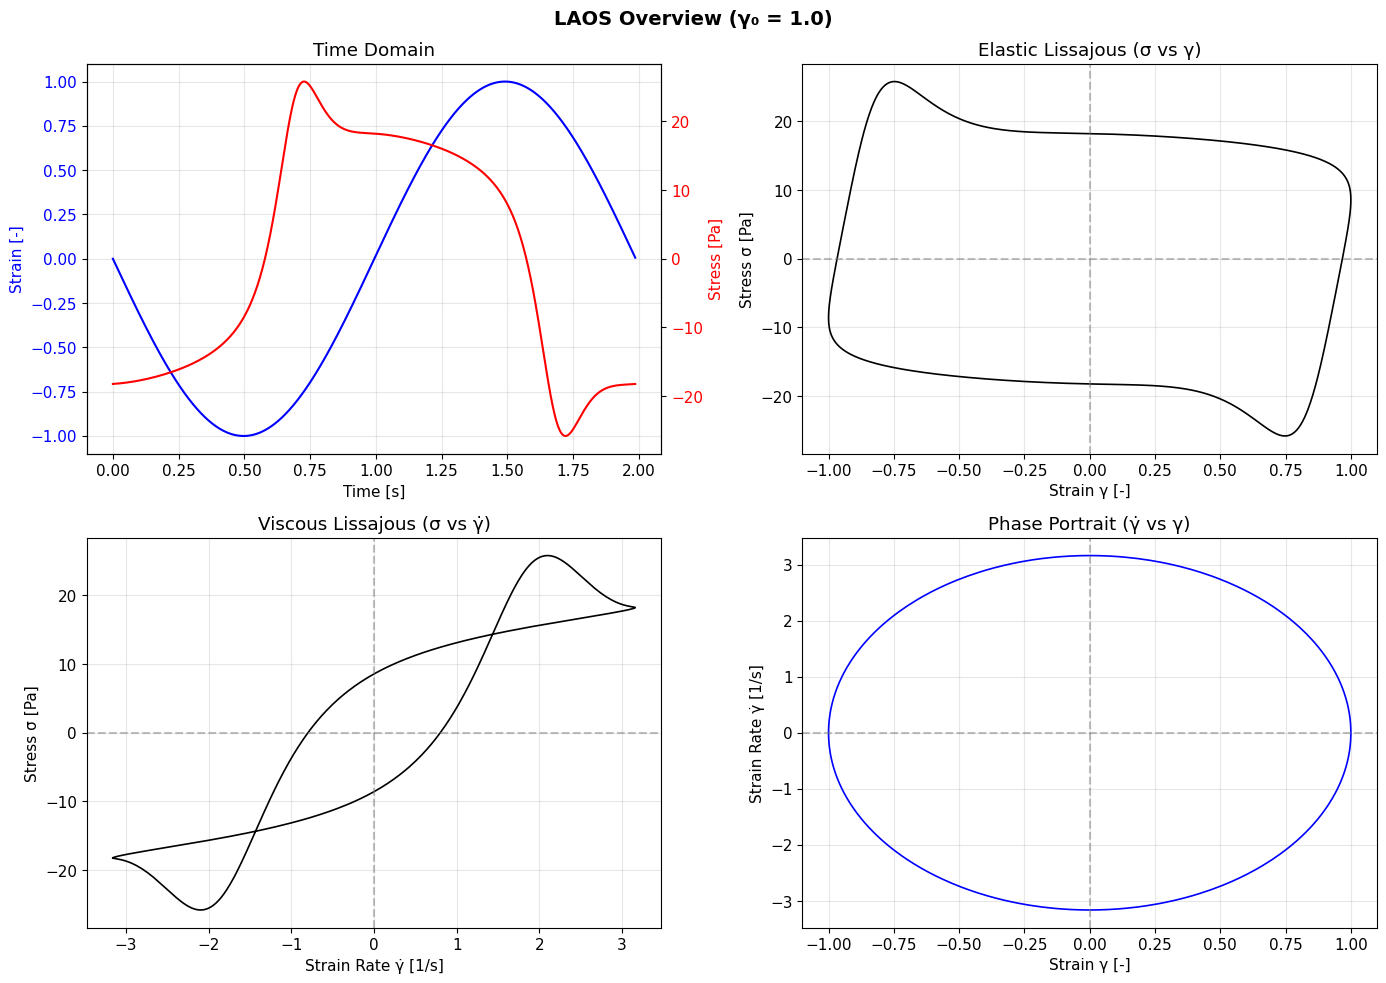

In [7]:
def plot_laos_overview(data: dict, title: str = "LAOS Waveforms"):
    """Create a 4-panel overview of LAOS data."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    gamma_0 = data['gamma_0']
    
    # Time domain waveforms
    ax1 = axes[0, 0]
    ax1.plot(data['time'], data['strain'], 'b-', label='Strain', linewidth=1.5)
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Strain [-]', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1_twin = ax1.twinx()
    ax1_twin.plot(data['time'], data['stress'], 'r-', label='Stress', linewidth=1.5)
    ax1_twin.set_ylabel('Stress [Pa]', color='r')
    ax1_twin.tick_params(axis='y', labelcolor='r')
    ax1.set_title('Time Domain')
    ax1.grid(True, alpha=0.3)
    
    # Elastic Lissajous (stress vs strain)
    ax2 = axes[0, 1]
    ax2.plot(data['strain'], data['stress'], 'k-', linewidth=1.2)
    ax2.set_xlabel('Strain γ [-]')
    ax2.set_ylabel('Stress σ [Pa]')
    ax2.set_title('Elastic Lissajous (σ vs γ)')
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    
    # Viscous Lissajous (stress vs strain rate)
    ax3 = axes[1, 0]
    ax3.plot(data['strain_rate'], data['stress'], 'k-', linewidth=1.2)
    ax3.set_xlabel('Strain Rate γ̇ [1/s]')
    ax3.set_ylabel('Stress σ [Pa]')
    ax3.set_title('Viscous Lissajous (σ vs γ̇)')
    ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax3.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax3.grid(True, alpha=0.3)
    
    # Phase portrait (strain rate vs strain)
    ax4 = axes[1, 1]
    ax4.plot(data['strain'], data['strain_rate'], 'b-', linewidth=1.2)
    ax4.set_xlabel('Strain γ [-]')
    ax4.set_ylabel('Strain Rate γ̇ [1/s]')
    ax4.set_title('Phase Portrait (γ̇ vs γ)')
    ax4.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax4.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax4.grid(True, alpha=0.3)
    
    fig.suptitle(f"{title} (γ₀ = {gamma_0})", fontsize=14, fontweight='bold')
    fig.tight_layout()
    display(fig)
    plt.close(fig)


# Plot medium amplitude data
plot_laos_overview(laos_datasets['medium'], "LAOS Overview")

## 3. SPP Decomposition with RheoJAX

The `SPPDecomposer` transform extracts time-resolved material functions from LAOS data.

### Key Parameters

| Parameter | Description | Typical Values |
|-----------|-------------|----------------|
| `omega` | Angular frequency (rad/s) | From experiment |
| `gamma_0` | Strain amplitude | From experiment |
| `n_harmonics` | Number of harmonics for Fourier analysis | 15-81 |
| `use_numerical_method` | Use numerical vs Fourier method | False (Fourier) |
| `step_size` | Step size for numerical differentiation | 8 |

In [8]:
# Select dataset for detailed analysis
sample_name = 'medium'
data = laos_datasets[sample_name]
params = EXPERIMENTS[sample_name]

# Create RheoData object
rheo_data = RheoData(
    x=data['time'],
    y=data['stress'],
    domain='time',
    x_units='s',
    y_units='Pa',
    metadata={
        'test_mode': 'oscillation',
        'omega': OMEGA,
        'gamma_0': params['gamma_0'],
        'strain': data['strain'],
        'strain_rate': data['strain_rate'],
    },
    validate=False,
)

print(f"Created RheoData object:")
print(f"  Domain: {rheo_data.domain}")
print(f"  Points: {len(rheo_data.x)}")
print(f"  omega: {rheo_data.metadata['omega']} rad/s")
print(f"  gamma_0: {rheo_data.metadata['gamma_0']}")

Created RheoData object:
  Domain: time
  Points: 1024
  omega: 3.16 rad/s
  gamma_0: 1.0


In [9]:
# Initialize SPP Decomposer
decomposer = SPPDecomposer(
    omega=OMEGA,
    gamma_0=params['gamma_0'],
    n_harmonics=params['n_harmonics'],
    use_numerical_method=False,  # Fourier method (recommended)
    step_size=8,
)

print("SPPDecomposer Configuration:")
print(f"  ω = {decomposer.omega} rad/s")
print(f"  γ₀ = {decomposer.gamma_0}")
print(f"  γ̇₀ = {decomposer.gamma_dot_0:.4f} 1/s")
print(f"  Harmonics: {decomposer.n_harmonics}")
print(f"  Method: {'Numerical' if decomposer.use_numerical_method else 'Fourier'}")

SPPDecomposer Configuration:
  ω = 3.16 rad/s
  γ₀ = 1.0
  γ̇₀ = 3.1600 1/s
  Harmonics: 39
  Method: Fourier


In [10]:
# Apply SPP decomposition
result = decomposer.transform(rheo_data)

# Get all SPP results
spp_results = decomposer.get_results()

print("SPP Decomposition Complete!")
print("\n" + "="*50)
print("KEY RESULTS")
print("="*50)

print("\n📊 Yield Stresses:")
print(f"   Static yield stress (σ_sy):  {spp_results['sigma_sy']:.4f} Pa")
print(f"   Dynamic yield stress (σ_dy): {spp_results['sigma_dy']:.4f} Pa")

print("\n📈 Time-Averaged Moduli:")
if 'Gp_t_mean' in spp_results:
    print(f"   Mean G'_t:  {spp_results['Gp_t_mean']:.4f} Pa")
    print(f"   Mean G''_t: {spp_results['Gpp_t_mean']:.4f} Pa")

print("\n📐 Lissajous Metrics:")
print(f"   G_L (large strain modulus):   {spp_results['G_L']:.4f} Pa")
print(f"   G_M (minimum strain modulus): {spp_results['G_M']:.4f} Pa")
print(f"   S-factor (strain stiffening): {spp_results['S_factor']:.4f}")
print(f"   T-factor (shear thickening):  {spp_results['T_factor']:.4f}")

print("\n🔬 Harmonic Analysis:")
print(f"   Fundamental amplitude: {spp_results['fundamental_amplitude']:.4f} Pa")
print(f"   I₃/I₁ ratio: {spp_results['I3_I1_ratio']:.6f}")

print("\n📦 Available Arrays:")
print(f"   G_cage, sigma_elastic, sigma_viscous, stress_reconstructed")
if 'core' in spp_results:
    print(f"   core: Gp_t, Gpp_t, G_star_t, tan_delta_t, delta_t, disp_stress, ...")

SPP Decomposition Complete!

KEY RESULTS

📊 Yield Stresses:
   Static yield stress (σ_sy):  8.1194 Pa
   Dynamic yield stress (σ_dy): 8.5646 Pa

📈 Time-Averaged Moduli:
   Mean G'_t:  1.4965 Pa
   Mean G''_t: 22.4986 Pa

📐 Lissajous Metrics:
   G_L (large strain modulus):   8.1194 Pa
   G_M (minimum strain modulus): -0.8487 Pa
   S-factor (strain stiffening): 1.1045
   T-factor (shear thickening):  -0.1659

🔬 Harmonic Analysis:
   Fundamental amplitude: 22.5483 Pa
   I₃/I₁ ratio: 0.287049

📦 Available Arrays:
   G_cage, sigma_elastic, sigma_viscous, stress_reconstructed
   core: Gp_t, Gpp_t, G_star_t, tan_delta_t, delta_t, disp_stress, ...


## 4. Time-Resolved Material Functions

The key advantage of SPP is extracting **instantaneous** material properties throughout the oscillation cycle, revealing how the material response changes with strain and strain rate.

In [11]:
# Extract time-resolved results
if 'core' in spp_results:
    core = spp_results['core']
    time_spp = core.get('time_new', data['time'])
    Gp_t = core['Gp_t']
    Gpp_t = core['Gpp_t']
    G_star_t = core['G_star_t']
    tan_delta_t = core['tan_delta_t']
    delta_t = core['delta_t']
    disp_stress = core['disp_stress']
    
    print("Extracted time-resolved SPP results:")
    print(f"  G'_t range: [{Gp_t.min():.4f}, {Gp_t.max():.4f}] Pa")
    print(f"  G''_t range: [{Gpp_t.min():.4f}, {Gpp_t.max():.4f}] Pa")
    print(f"  |G*_t| range: [{G_star_t.min():.4f}, {G_star_t.max():.4f}] Pa")
    print(f"  δ_t range: [{delta_t.min():.4f}, {delta_t.max():.4f}] rad")
else:
    print("Core SPP results not available")
    time_spp = data['time']
    Gp_t = spp_results.get('G_cage', np.zeros_like(data['time']))

Extracted time-resolved SPP results:
  G'_t range: [-310.0434, 183.0528] Pa
  G''_t range: [-63.1224, 270.8176] Pa
  |G*_t| range: [0.7125, 411.6662] Pa
  δ_t range: [-1.5639, 4.7039] rad


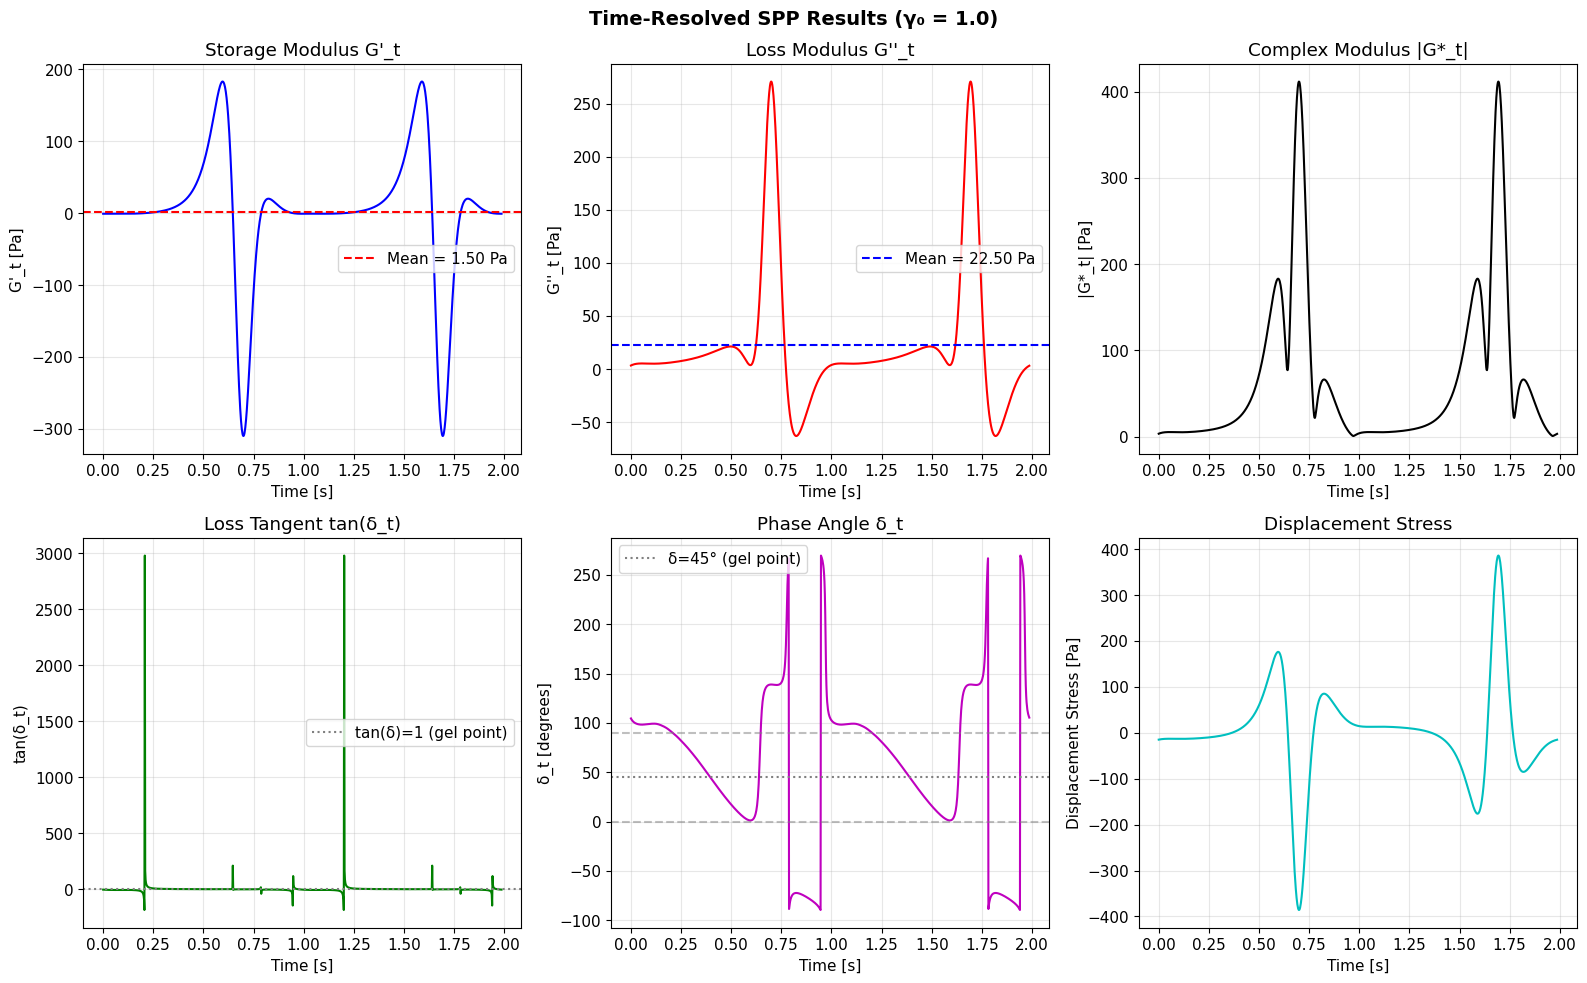

In [12]:
if 'core' in spp_results:
    # Plot time-resolved material functions
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # G'_t
    ax1 = axes[0, 0]
    ax1.plot(time_spp, Gp_t, 'b-', linewidth=1.5)
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel("G'_t [Pa]")
    ax1.set_title("Storage Modulus G'_t")
    ax1.axhline(y=spp_results['Gp_t_mean'], color='r', linestyle='--', 
                label=f"Mean = {spp_results['Gp_t_mean']:.2f} Pa")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # G''_t
    ax2 = axes[0, 1]
    ax2.plot(time_spp, Gpp_t, 'r-', linewidth=1.5)
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel("G''_t [Pa]")
    ax2.set_title("Loss Modulus G''_t")
    ax2.axhline(y=spp_results['Gpp_t_mean'], color='b', linestyle='--',
                label=f"Mean = {spp_results['Gpp_t_mean']:.2f} Pa")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # |G*_t|
    ax3 = axes[0, 2]
    ax3.plot(time_spp, G_star_t, 'k-', linewidth=1.5)
    ax3.set_xlabel('Time [s]')
    ax3.set_ylabel('|G*_t| [Pa]')
    ax3.set_title('Complex Modulus |G*_t|')
    ax3.grid(True, alpha=0.3)
    
    # tan(δ_t)
    ax4 = axes[1, 0]
    ax4.plot(time_spp, tan_delta_t, 'g-', linewidth=1.5)
    ax4.set_xlabel('Time [s]')
    ax4.set_ylabel('tan(δ_t)')
    ax4.set_title('Loss Tangent tan(δ_t)')
    ax4.axhline(y=1, color='gray', linestyle=':', label='tan(δ)=1 (gel point)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # δ_t
    ax5 = axes[1, 1]
    ax5.plot(time_spp, np.degrees(delta_t), 'm-', linewidth=1.5)
    ax5.set_xlabel('Time [s]')
    ax5.set_ylabel('δ_t [degrees]')
    ax5.set_title('Phase Angle δ_t')
    ax5.axhline(y=45, color='gray', linestyle=':', label='δ=45° (gel point)')
    ax5.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax5.axhline(y=90, color='gray', linestyle='--', alpha=0.5)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Displacement stress
    ax6 = axes[1, 2]
    ax6.plot(time_spp, disp_stress, 'c-', linewidth=1.5)
    ax6.set_xlabel('Time [s]')
    ax6.set_ylabel('Displacement Stress [Pa]')
    ax6.set_title('Displacement Stress')
    ax6.grid(True, alpha=0.3)
    
    plt.suptitle(f'Time-Resolved SPP Results (γ₀ = {params["gamma_0"]})', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    display(fig)
    plt.close(fig)

## 5. Cole-Cole Plot

The Cole-Cole plot (G'' vs G') visualizes how the viscoelastic character changes throughout the oscillation cycle. Linear materials trace a single point; nonlinear materials trace trajectories.

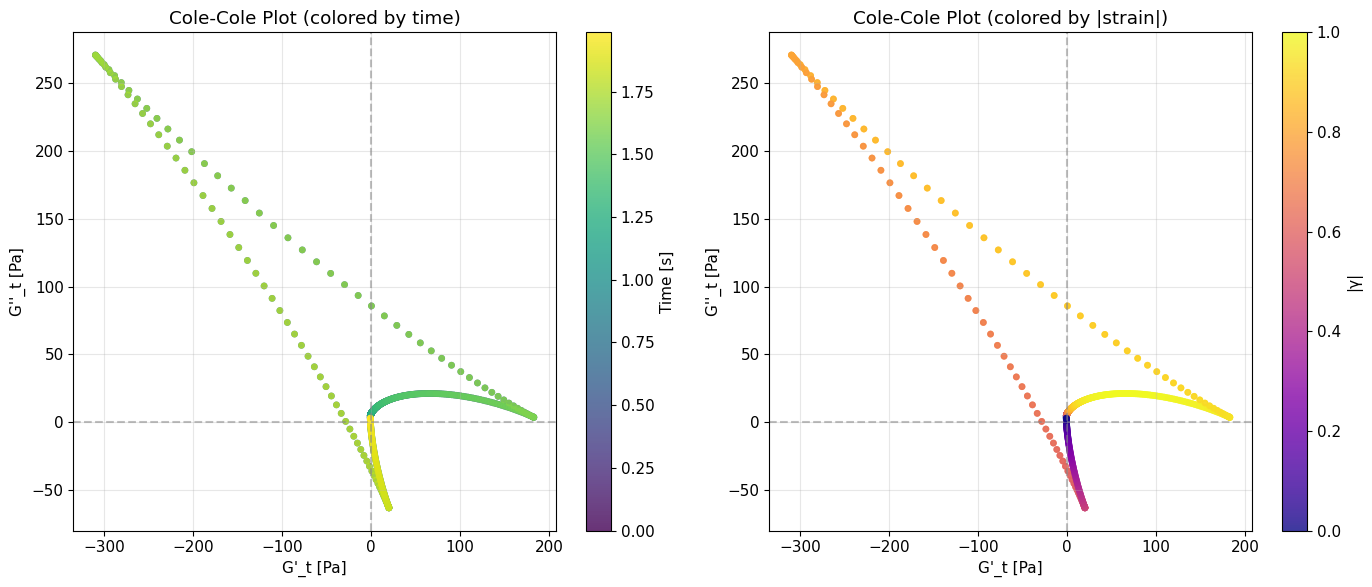

In [13]:
if 'core' in spp_results:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Cole-Cole plot colored by time
    ax1 = axes[0]
    scatter = ax1.scatter(Gp_t, Gpp_t, c=time_spp, cmap='viridis', s=15, alpha=0.8)
    ax1.set_xlabel("G'_t [Pa]")
    ax1.set_ylabel("G''_t [Pa]")
    ax1.set_title('Cole-Cole Plot (colored by time)')
    plt.colorbar(scatter, ax=ax1, label='Time [s]')
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax1.grid(True, alpha=0.3)
    
    # Cole-Cole plot colored by strain
    ax2 = axes[1]
    strain_interp = np.interp(time_spp, data['time'], data['strain'])
    scatter2 = ax2.scatter(Gp_t, Gpp_t, c=np.abs(strain_interp), cmap='plasma', s=15, alpha=0.8)
    ax2.set_xlabel("G'_t [Pa]")
    ax2.set_ylabel("G''_t [Pa]")
    ax2.set_title('Cole-Cole Plot (colored by |strain|)')
    plt.colorbar(scatter2, ax=ax2, label='|γ|')
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    display(fig)
    plt.close(fig)

## 6. Strain Amplitude Sweep Analysis

A key application of SPP is analyzing how nonlinearity develops with increasing strain amplitude. Let's process all three strain amplitudes and compare.

In [14]:
# Process all strain amplitudes
all_spp_results = {}

for name, exp_params in EXPERIMENTS.items():
    data = laos_datasets[name]
    
    # Create RheoData
    rheo = RheoData(
        x=data['time'],
        y=data['stress'],
        domain='time',
        metadata={
            'test_mode': 'oscillation',
            'omega': OMEGA,
            'gamma_0': exp_params['gamma_0'],
            'strain': data['strain'],
            'strain_rate': data['strain_rate'],
        },
        validate=False,
    )
    
    # Apply SPP decomposition
    spp = SPPDecomposer(
        omega=OMEGA,
        gamma_0=exp_params['gamma_0'],
        n_harmonics=exp_params['n_harmonics'],
        use_numerical_method=False,
        step_size=8,
    )
    
    spp.transform(rheo)
    results = spp.get_results()
    
    all_spp_results[name] = {
        'params': exp_params,
        'data': data,
        'spp_results': results,
    }
    
    print(f"✓ Processed '{name}' (γ₀ = {exp_params['gamma_0']})")

print("\nAll datasets processed successfully!")

✓ Processed 'low' (γ₀ = 0.1)
✓ Processed 'medium' (γ₀ = 1.0)


✓ Processed 'high' (γ₀ = 10.0)

All datasets processed successfully!


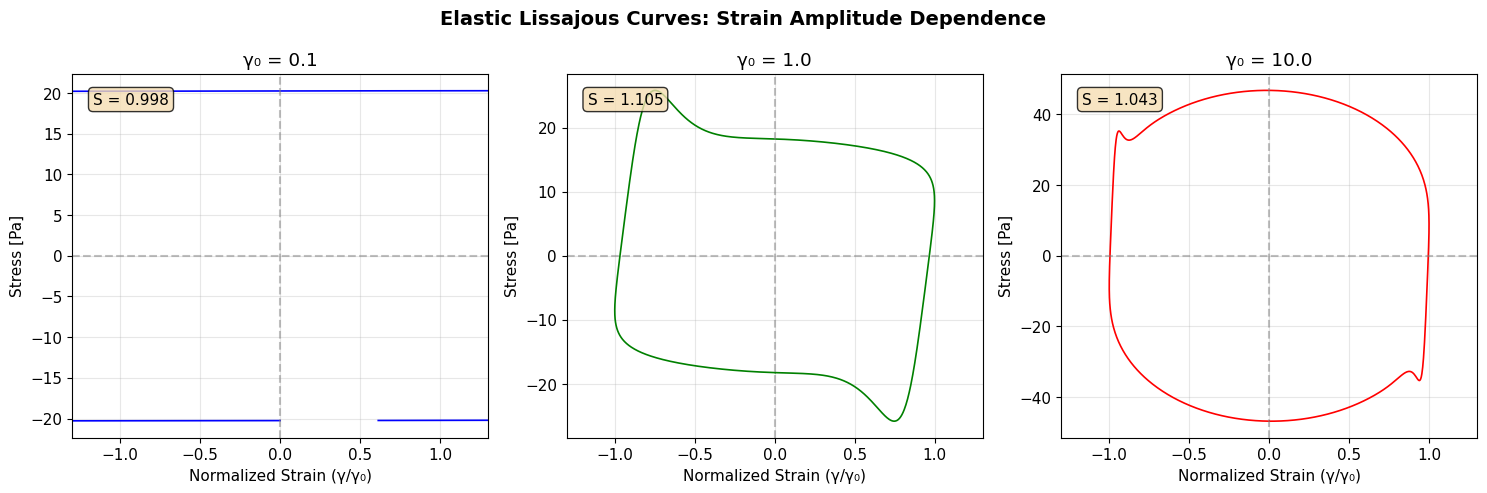

In [15]:
# Compare Lissajous curves across strain amplitudes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = ['blue', 'green', 'red']

for idx, (name, res) in enumerate(all_spp_results.items()):
    data = res['data']
    gamma_0 = res['params']['gamma_0']
    
    # Normalize strain for comparison
    strain_norm = data['strain'] / gamma_0
    
    ax = axes[idx]
    ax.plot(strain_norm, data['stress'], color=colors[idx], linewidth=1.2)
    ax.set_xlabel('Normalized Strain (γ/γ₀)')
    ax.set_ylabel('Stress [Pa]')
    ax.set_title(f'γ₀ = {gamma_0}')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlim(-1.3, 1.3)
    ax.grid(True, alpha=0.3)
    
    # Add S-factor annotation
    S = res['spp_results']['S_factor']
    ax.text(0.05, 0.95, f'S = {S:.3f}', transform=ax.transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('Elastic Lissajous Curves: Strain Amplitude Dependence', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
display(fig)
plt.close(fig)

In [16]:
# Summary table of SPP metrics
summary_data = []
for name, res in all_spp_results.items():
    r = res['spp_results']
    p = res['params']
    summary_data.append({
        'Name': name,
        'γ₀': p['gamma_0'],
        'Harmonics': p['n_harmonics'],
        'σ_sy [Pa]': r['sigma_sy'],
        'σ_dy [Pa]': r['sigma_dy'],
        'G_L [Pa]': r['G_L'],
        'G_M [Pa]': r['G_M'],
        'S-factor': r['S_factor'],
        'T-factor': r['T_factor'],
        'I₃/I₁': r['I3_I1_ratio'],
    })

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("SPP ANALYSIS SUMMARY: Strain Amplitude Sweep")
print("="*80)
print(summary_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))


SPP ANALYSIS SUMMARY: Strain Amplitude Sweep
  Name      γ₀  Harmonics  σ_sy [Pa]  σ_dy [Pa]  G_L [Pa]  G_M [Pa]  S-factor  T-factor  I₃/I₁
   low  0.1000         15    12.1680     8.9364  121.6797    0.2616    0.9979    0.9920 0.1621
medium  1.0000         39     8.1194     8.5646    8.1194   -0.8487    1.1045   -0.1659 0.2870
  high 10.0000         81    10.2599     8.6515    1.0260   -0.0446    1.0435   -0.5135 0.1300


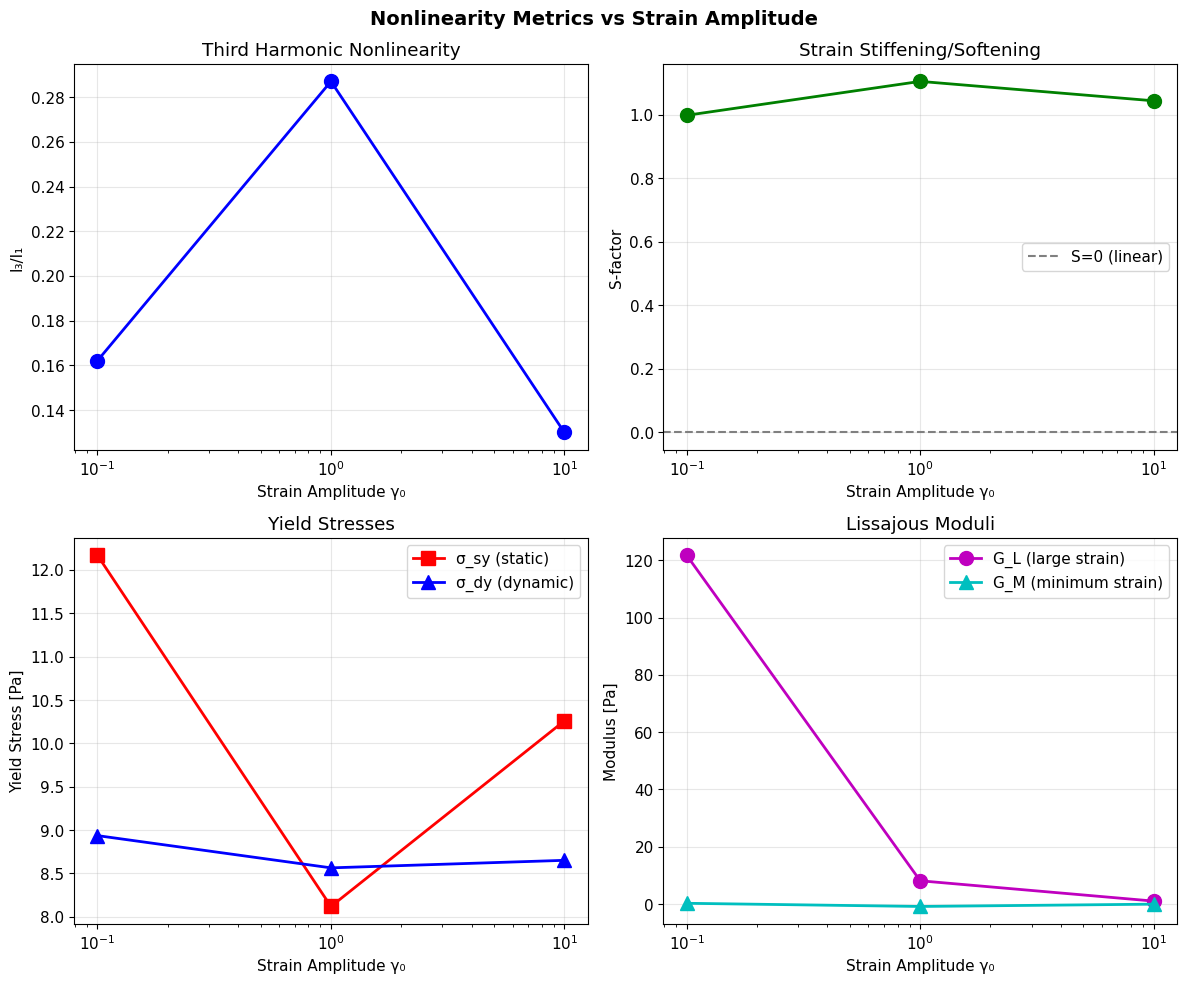

In [17]:
# Plot nonlinearity metrics vs strain amplitude
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

gamma_0_values = [res['params']['gamma_0'] for res in all_spp_results.values()]

# I3/I1 ratio (FT-rheology nonlinearity)
ax1 = axes[0, 0]
I3_I1_values = [res['spp_results']['I3_I1_ratio'] for res in all_spp_results.values()]
ax1.semilogx(gamma_0_values, I3_I1_values, 'bo-', markersize=10, linewidth=2)
ax1.set_xlabel('Strain Amplitude γ₀')
ax1.set_ylabel('I₃/I₁')
ax1.set_title('Third Harmonic Nonlinearity')
ax1.grid(True, alpha=0.3)

# S-factor (strain stiffening)
ax2 = axes[0, 1]
S_values = [res['spp_results']['S_factor'] for res in all_spp_results.values()]
ax2.semilogx(gamma_0_values, S_values, 'go-', markersize=10, linewidth=2)
ax2.axhline(y=0, color='gray', linestyle='--', label='S=0 (linear)')
ax2.set_xlabel('Strain Amplitude γ₀')
ax2.set_ylabel('S-factor')
ax2.set_title('Strain Stiffening/Softening')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Yield stresses
ax3 = axes[1, 0]
sigma_sy = [res['spp_results']['sigma_sy'] for res in all_spp_results.values()]
sigma_dy = [res['spp_results']['sigma_dy'] for res in all_spp_results.values()]
ax3.semilogx(gamma_0_values, sigma_sy, 'rs-', markersize=10, linewidth=2, label='σ_sy (static)')
ax3.semilogx(gamma_0_values, sigma_dy, 'b^-', markersize=10, linewidth=2, label='σ_dy (dynamic)')
ax3.set_xlabel('Strain Amplitude γ₀')
ax3.set_ylabel('Yield Stress [Pa]')
ax3.set_title('Yield Stresses')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Lissajous moduli
ax4 = axes[1, 1]
G_L = [res['spp_results']['G_L'] for res in all_spp_results.values()]
G_M = [res['spp_results']['G_M'] for res in all_spp_results.values()]
ax4.semilogx(gamma_0_values, G_L, 'mo-', markersize=10, linewidth=2, label='G_L (large strain)')
ax4.semilogx(gamma_0_values, G_M, 'c^-', markersize=10, linewidth=2, label='G_M (minimum strain)')
ax4.set_xlabel('Strain Amplitude γ₀')
ax4.set_ylabel('Modulus [Pa]')
ax4.set_title('Lissajous Moduli')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Nonlinearity Metrics vs Strain Amplitude', fontsize=14, fontweight='bold')
plt.tight_layout()
display(fig)
plt.close(fig)

## 7. Interpreting SPP Results

### Key Metrics Explained

| Metric | Physical Meaning | Typical Interpretation |
|--------|------------------|------------------------|
| **σ_sy** | Static yield stress | Stress at maximum strain (strain reversal) |
| **σ_dy** | Dynamic yield stress | Stress at zero strain rate (rate reversal) |
| **G_L** | Large strain modulus | Tangent modulus at γ = γ₀ |
| **G_M** | Minimum strain modulus | Tangent modulus at γ = 0 |
| **S-factor** | Strain stiffening ratio | S > 0: stiffening, S < 0: softening |
| **T-factor** | Shear thickening ratio | T > 0: thickening, T < 0: thinning |
| **I₃/I₁** | Third harmonic ratio | Nonlinearity indicator (0 = linear) |

### Material Classification from SPP

- **Linear response**: S ≈ 0, T ≈ 0, I₃/I₁ < 0.01
- **Strain stiffening**: S > 0 (e.g., biopolymer networks)
- **Strain softening**: S < 0 (e.g., yield stress fluids)
- **Shear thickening**: T > 0 (e.g., dense suspensions)
- **Shear thinning**: T < 0 (e.g., polymer solutions)

In [18]:
# Classify material behavior at each strain amplitude
print("\n" + "="*60)
print("MATERIAL BEHAVIOR CLASSIFICATION")
print("="*60)

for name, res in all_spp_results.items():
    r = res['spp_results']
    gamma_0 = res['params']['gamma_0']
    
    print(f"\n📊 {name.upper()} (γ₀ = {gamma_0}):")
    
    # Nonlinearity assessment
    I3_I1 = r['I3_I1_ratio']
    if I3_I1 < 0.01:
        print(f"   Linearity: Nearly linear (I₃/I₁ = {I3_I1:.4f})")
    elif I3_I1 < 0.1:
        print(f"   Linearity: Weakly nonlinear (I₃/I₁ = {I3_I1:.4f})")
    else:
        print(f"   Linearity: Strongly nonlinear (I₃/I₁ = {I3_I1:.4f})")
    
    # Strain behavior
    S = r['S_factor']
    if abs(S) < 0.1:
        print(f"   Strain behavior: Linear elastic (S = {S:.4f})")
    elif S > 0:
        print(f"   Strain behavior: Strain STIFFENING (S = {S:.4f})")
    else:
        print(f"   Strain behavior: Strain SOFTENING (S = {S:.4f})")
    
    # Rate behavior
    T = r['T_factor']
    if abs(T) < 0.1:
        print(f"   Rate behavior: Newtonian-like (T = {T:.4f})")
    elif T > 0:
        print(f"   Rate behavior: Shear THICKENING (T = {T:.4f})")
    else:
        print(f"   Rate behavior: Shear THINNING (T = {T:.4f})")


MATERIAL BEHAVIOR CLASSIFICATION

📊 LOW (γ₀ = 0.1):
   Linearity: Strongly nonlinear (I₃/I₁ = 0.1621)
   Strain behavior: Strain STIFFENING (S = 0.9979)
   Rate behavior: Shear THICKENING (T = 0.9920)

📊 MEDIUM (γ₀ = 1.0):
   Linearity: Strongly nonlinear (I₃/I₁ = 0.2870)
   Strain behavior: Strain STIFFENING (S = 1.1045)
   Rate behavior: Shear THINNING (T = -0.1659)

📊 HIGH (γ₀ = 10.0):
   Linearity: Strongly nonlinear (I₃/I₁ = 0.1300)
   Strain behavior: Strain STIFFENING (S = 1.0435)
   Rate behavior: Shear THINNING (T = -0.5135)


## 8. Convenience Functions

RheoJAX provides convenience functions for quick SPP analysis without creating RheoData objects.

In [19]:
from rheojax.transforms.spp_decomposer import spp_analyze

# Quick analysis using convenience function
data = laos_datasets['medium']

quick_results = spp_analyze(
    stress=data['stress'],
    time=data['time'],
    omega=OMEGA,
    gamma_0=1.0,
    strain=data['strain'],
    n_harmonics=39,
)

print("Quick SPP Analysis Results:")
print(f"  σ_sy = {quick_results['sigma_sy']:.4f} Pa")
print(f"  σ_dy = {quick_results['sigma_dy']:.4f} Pa")
print(f"  S-factor = {quick_results['S_factor']:.4f}")
print(f"  I₃/I₁ = {quick_results['I3_I1_ratio']:.6f}")

Quick SPP Analysis Results:
  σ_sy = 8.1194 Pa
  σ_dy = 8.5646 Pa
  S-factor = 1.1045
  I₃/I₁ = 0.287049


## Summary

This tutorial covered:

1. **Loading LAOS data**: Preparing time-domain stress and strain signals
2. **SPPDecomposer configuration**: Setting frequency, strain amplitude, and harmonics
3. **Time-resolved analysis**: Extracting G'_t, G''_t, δ_t throughout the cycle
4. **Cole-Cole visualization**: Understanding viscoelastic character evolution
5. **Amplitude sweep**: Quantifying nonlinearity development with strain
6. **Material classification**: Interpreting S-factor, T-factor, and I₃/I₁

### Key Takeaways

- SPP provides **instantaneous** material properties, not cycle-averaged values
- The **S-factor** and **T-factor** quantify strain stiffening and shear thickening
- **I₃/I₁** measures overall nonlinearity from harmonic content
- Cole-Cole plots reveal how viscoelastic character changes during deformation

### References

- Rogers, S.A., et al. "A sequence of physical processes determined and quantified in large-amplitude oscillatory shear (LAOS): Application to theoretical nonlinear models." *J. Rheol.* 56(1), 2012.
- Rogers, S.A. "In search of physical meaning: Defining transient parameters for nonlinear viscoelasticity." *Rheol. Acta* 56, 2017.
- Ewoldt, R.H., Hosoi, A.E., McKinley, G.H. "New measures for characterizing nonlinear viscoelasticity in large amplitude oscillatory shear." *J. Rheol.* 52(6), 2008.